c:\Users\Dolly\.conda\envs\hackathon\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
diffusion_pytorch_model.safetensors not found
Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]An error occurred while trying to fetch C:\Users\Dolly\.cache\huggingface\hub\models--google--ddpm-celebahq-256\snapshots\cd5c944777ea2668051904ead6cc120739b86c4d: Error no file named diffusion_pytorch_model.safetensors found in directory C:\Users\Dolly\.cache\huggingface\hub\models--google--ddpm-celebahq-256\snapshots\cd5c944777ea2668051904ead6cc120739b86c4d.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
Loading pipeline components...: 100%|██████████| 2/2 [00:00<00:00,  5.54it/s]
c:\Users\Dolly\.conda\envs\hackathon\lib\site-packages\torch\utils\_device.py:78: UserWarning: 

Time: 8.794321298599243
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Dolly\.conda\envs\hackathon\lib\site-packages\lpips\weights\v0.1\alex.pth


c:\Users\Dolly\.conda\envs\hackathon\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Dolly\.conda\envs\hackathon\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\Dolly\\Documents\\My_Files\\code\\diffusion-hackathon\\output\\dps_dpms_n_step=100_sigma=0.01_k=10.png'

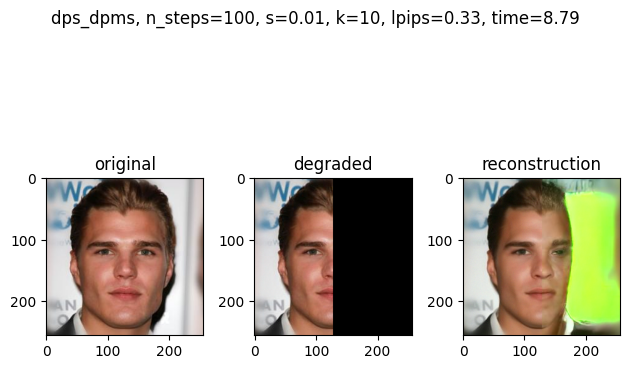

In [1]:
import torch

from utils import load_epsilon_net, load_image
from utils import load_epsilon_net
from sampling.dps import dps
from sampling.dps_dpms import dps_dpms
from time import time
from evaluation.perception import LPIPS
from sampling.dmps import dpms
from matplotlib import pyplot as plt
from utils import display_image

device = "cuda:0"
#n_steps = 100
torch.set_default_device(device)


# load the image
img_path = "./hackathon_starter_kit/material/celebahq_img/00010.jpg"
x_origin = load_image(img_path, device)


# load the degradation operator
#path_operator = f"./material/degradation_operators/sr16.pt"
path_operator = f"./hackathon_starter_kit/material/degradation_operators/outpainting_half.pt"
degradation_operator = torch.load(path_operator, map_location=device)

# apply degradation operator
y = degradation_operator.H(x_origin[None])
y = y.squeeze(0)

#sigma = [0.01, 0.05, 0.1]
#n_steps = [100, 300, 500, 1000]
sigma = [0.01]
n_steps = [100]


method = "dps_dpms"

output_dir= "./output/"



for n in n_steps:
    for s in sigma:
        if method == "dps_dpms":
            K = [int(n/10), int(n/5), int(n/2)]
        else:
            K = [0]
        for k in K:

            # add noise
            y = y + s * torch.randn_like(y)

            # define inverse problem
            inverse_problem = (y, degradation_operator, s)

            # load model
            eps_net = load_epsilon_net("celebahq", n, device)

            # solve problem
            initial_noise = torch.randn((1, 3, 256, 256), device=device)
            # start_time = time()
            # #reconstruction = dps(initial_noise, inverse_problem, eps_net)
            # reconstruction = dps_dpms(initial_noise, inverse_problem, eps_net, k = k)
            # #reconstruction = dpms(initial_noise, inverse_problem, eps_net)
            # end_time = time()

            start = time()
            if method == "dpms":
                reconstruction = dpms(initial_noise, inverse_problem, eps_net)
                output_path = output_dir + f"/{method}_n_step={n}_sigma={s}.png"
            if method == "dps":
                reconstruction = dps(initial_noise, inverse_problem, eps_net)
                output_path = output_dir + f"/{method}_n_step={n}_sigma={s}.png"
            if method == "dps_dpms":
                reconstruction = dps_dpms(initial_noise, inverse_problem, eps_net,k=k)
                output_path = output_dir + f"/{method}_n_step={n}_sigma={s}_k={k}.png"
            end = time()
            print(f"Time: {end-start}")
            reconstruction.clamp(-1, 1)
            #display the results
            # reshape y
            y_reshaped =  -torch.ones(3 * 256 * 256, device=device)
            y_reshaped[: y.shape[0]] = y
            y_reshaped = degradation_operator.V(y_reshaped[None])
            y_reshaped = y_reshaped.reshape(3, 256, 256)

            #metric calculation
            lpips =  LPIPS()
            lpips_score = lpips.score(reconstruction.clamp(-1, 1), x_origin)

            # init figure
            fig, axes = plt.subplots(1, 3)

            images = (x_origin, y_reshaped, reconstruction[0])
            titles = ("original", "degraded", "reconstruction")

            # display figures
            
            for ax, img, title in zip(axes, images,titles):
                display_image(img, ax)
                ax.set_title(title)
            if method == "dps_dpms":
                fig.suptitle(f"{method}, n_steps={n}, s={s}, k={k}, lpips={round(lpips_score.item(),2)}, time={round(end-start,2)}")
            else:
                fig.suptitle(f"{method}, n_steps={n}, s={s}, lpips={round(lpips_score.item(),2)}, time={round(end-start,2)}")
            fig.tight_layout()
            fig.savefig(output_path)
            plt.close(fig)
            #print("Time elapsed: ", end_time - start_time)